In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from candidate_element import score_by_elt
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# # Review unperturbed elements
# elts_ast

In [10]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert = perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                         sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                         sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                         mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Review perturbed elements
# elts_pert

In [12]:
# Random elements
elts_rand = random_elts(element_id_start=0, size=batch_size,
                        random_seed=random_seed, dtype=dtype_np)

In [13]:
# Review random elements
# elts_rand

## Batches of ZTF Data vs. Elements

In [14]:
# Arguments to make_ztf_batch
thresh_deg = 1.0
# thresh_deg = 2.0
# thresh_deg = 4.0
near_ast = False
regenerate = False

In [15]:
# Load unperturbed element batch
ztf_elt_ast = load_ztf_batch(elts=elts_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [16]:
# Load perturbed element batch
ztf_elt_pert = load_ztf_batch(elts=elts_pert, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [17]:
# Load random element batch
ztf_elt_rand = load_ztf_batch(elts=elts_rand, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
# Score by element - unperturbed
score_by_elt_ast = ztf_score_by_elt(ztf_elt_ast)

In [19]:
# Score by element - perturbed
score_by_elt_pert = ztf_score_by_elt(ztf_elt_pert)

In [20]:
# Score by element - random
score_by_elt_rand = ztf_score_by_elt(ztf_elt_rand)

In [21]:
# Summarize the ztf element batch: unperturbed asteroids
ztf_elt_summary(ztf_elt_ast, score_by_elt_ast, 'Unperturbed Asteroids')

ZTF Element Dataframe Unperturbed Asteroids:
                  Total     (Per Batch)
Observations   :   322914   (     5046)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :    2908.12
Sqrt(batch_obs):      71.03
Mean t_score   :      45.02


In [22]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt_pert, score_by_elt_pert, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [23]:
# Summarize the ztf element batch: random elements
ztf_elt_summary(ztf_elt_rand, score_by_elt_rand, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   265278   (     4211)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      54.71
Sqrt(batch_obs):      64.89
Mean t_score   :       0.27


In [24]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 1.0

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts_ast, score_by_elt=score_by_elt_ast, num_hits=num_hits, R_deg=R_deg)
elts_add_mixture_params(elts=elts_pert, score_by_elt=score_by_elt_pert, num_hits=num_hits, R_deg=R_deg)
elts_add_mixture_params(elts=elts_rand, score_by_elt=score_by_elt_rand, num_hits=num_hits, R_deg=R_deg)

In [26]:
# Review unperturbed elements
elts_ast

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,0.004274,0.017453
1,59244,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0,0.007025,0.017453
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,0.005582,0.017453
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0,0.005266,0.017453
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,0.005328,0.017453
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,0.001716,0.017453
60,134815,2.612770,0.140831,0.513922,0.272689,0.645552,-0.957836,58600.0,0.006124,0.017453
61,27860,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0,0.003126,0.017453
62,85937,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,0.007110,0.017453


## View Example DataFrames and Hits

In [27]:
# Review ztf_elt DataFrame
ztf_elt_ast

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,-0.063945,-0.983101,...,0.004080,-0.057300,-0.982042,0.179751,2.234078,0.010624,2191.408734,0.999944,0.092645,False
1,73603,733,b'ZTF18ablwzmb',609167834815015007,7226,58363.167836,265.761064,-13.509195,-0.071871,-0.982579,...,0.003999,-0.055041,-0.979702,0.192757,2.397172,0.027352,5641.954857,0.999626,0.614061,False
2,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,-0.071871,-0.982578,...,0.004080,-0.057300,-0.982042,0.179751,2.234078,0.016809,3467.151428,0.999859,0.231907,False
3,73605,733,b'ZTF18ablwzmb',584189894815015004,4646,58338.189896,265.761079,-13.509107,-0.071871,-0.982578,...,0.004126,-0.045072,-0.984663,0.168544,2.138928,0.027030,5575.548058,0.999635,0.599691,False
4,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,0.005674,-0.977422,...,0.003825,0.000919,-0.977996,0.208622,2.703478,0.005450,1124.103915,0.999985,0.024378,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322909,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,0.645100,0.733898,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.025126,5182.803024,0.999684,0.518186,False
322910,5651378,324582,b'ZTF20aaqvkyo',1150185754815015007,96635,58904.185752,42.122572,29.195466,0.647485,0.731228,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.029094,6001.222051,0.999577,0.694749,False
322911,5651434,324582,b'ZTF20aaqvkus',1150185310315015002,96634,58904.185313,43.256211,29.954124,0.631015,0.743348,...,-0.001541,0.627610,0.750725,0.206200,2.981912,0.017707,3652.453216,0.999843,0.257358,False
322912,5651513,324582,b'ZTF20aaqvlna',1150185755115015011,96635,58904.185752,42.388038,28.228923,0.650751,0.733102,...,-0.001541,0.627608,0.750726,0.206199,2.981918,0.030306,6251.306560,0.999541,0.753854,False


In [28]:
# Review hits
mask = ztf_elt_ast.is_hit
ztf_elt_ast[mask]

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
30,341737,733,b'ZTF19abizrac',937427766115015019,40797,58691.427766,33.130412,43.596186,0.606481,0.637452,...,-0.002127,0.606486,0.637448,0.475220,2.115260,0.000007,1.509138,1.0,4.393768e-08,True
33,345725,733,b'ZTF19abjajfg',937467364815015020,40840,58691.467361,33.148426,43.605278,0.606265,0.637618,...,-0.002129,0.606270,0.637614,0.475274,2.114851,0.000007,1.479386,1.0,4.222230e-08,True
36,346522,733,b'ZTF19abjajmr',937468726115015011,40842,58691.468727,33.149062,43.605587,0.606257,0.637624,...,-0.002129,0.606263,0.637619,0.475276,2.114837,0.000007,1.503609,1.0,4.361631e-08,True
40,347644,733,b'ZTF19abiyxiu',937402264815015008,40777,58691.402269,33.118785,43.590288,0.606621,0.637345,...,-0.002127,0.606626,0.637341,0.475186,2.115523,0.000007,1.491440,1.0,4.291319e-08,True
47,431445,733,b'ZTF19abkkfhr',934448315015015003,40221,58688.448310,31.751906,42.913068,0.622775,0.624451,...,-0.002040,0.622780,0.624447,0.471393,2.145603,0.000007,1.493960,1.0,4.305831e-08,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322817,5447574,324582,b'ZTF20aapdfmj',1145121244815015014,95204,58899.121250,42.392273,29.202629,0.644677,0.734024,...,-0.001502,0.644680,0.734021,0.213544,2.915471,0.000005,0.934688,1.0,1.685436e-08,True
322830,5450145,324582,b'ZTF20aapdfmj',1145121716115015016,95205,58899.121713,42.392439,29.202638,0.644675,0.734026,...,-0.001502,0.644678,0.734022,0.213543,2.915477,0.000005,1.005771,1.0,1.951541e-08,True
322844,5461311,324582,b'ZTF20aapeobw',1145164884815015018,95284,58899.164884,42.405891,29.202386,0.644538,0.734164,...,-0.001503,0.644541,0.734161,0.213479,2.916052,0.000004,0.890844,1.0,1.531025e-08,True
322845,5461312,324582,b'ZTF20aapeobw',1145165336115015009,95285,58899.165336,42.406082,29.202412,0.644536,0.734166,...,-0.001503,0.644540,0.734163,0.213478,2.916058,0.000005,1.056357,1.0,2.152784e-08,True


In [29]:
ztf_elt_ast.columns

Index(['ztf_id', 'element_id', 'ObjectID', 'CandidateID', 'TimeStampID', 'mjd',
       'ra', 'dec', 'ux', 'uy', 'uz', 'qx', 'qy', 'qz', 'vx', 'vy', 'vz',
       'elt_ux', 'elt_uy', 'elt_uz', 'elt_r', 's', 's_sec', 'z', 'v',
       'is_hit'],
      dtype='object')

In [30]:
# Alias ztf_elt_ast to ztf_elt
ztf_elt = ztf_elt_ast

In [31]:
# Build numpy array of times
ts_np = ztf_elt.mjd.values.astype(dtype_np)

# Get observation count per element
row_lengths_np = ztf_elt.element_id.groupby(ztf_elt.element_id).count().values.astype(np.int32)

In [32]:
# Review results
element_id_best = ast_num_best[0]
mask = (ztf_elt.element_id == element_id_best)
hits_best = np.sum(ztf_elt[mask].is_hit)
hit_rate_best = np.mean(ztf_elt[mask].is_hit)
rows_best = np.sum(mask)
s_sec_min = np.min(ztf_elt[mask].s_sec)
idx = np.argmin(ztf_elt.s)
ztf_id = ztf_elt.ztf_id[idx]
# ztf_elt[mask].iloc[idx:idx+1]
print(f'Best asteroid has element_id = {element_id_best}')
print(f'Hit count: {hits_best} / {rows_best} observations')
print(f'Hit rate : {hit_rate_best:8.6f}')
print(f'Closest hit: {s_sec_min:0.3f} arc seconds')
# ztf_elt[mask]

Best asteroid has element_id = 51921
Hit count: 158 / 2682 observations
Hit rate : 0.058911
Closest hit: 0.381 arc seconds


## Build "Gold" Asteroid Search Model (Reference)

In [33]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [34]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [35]:
# "Golden elements": unperturbed, with sharp resolution setting and approximately correct hit rate
elts_gold = elts_ast.copy()
score_by_elt_gold = score_by_elt_ast.copy()
ztf_elt_gold = ztf_elt_ast.copy()

# The "gold" model has a big number of hits and a resolution of 10 arc seconds
elts_add_mixture_params(elts=elts_gold, score_by_elt=score_by_elt_gold, num_hits=160, R_deg=10.0/3600.0, dtype=np.float32)

In [36]:
# Build asteroid search model
model_gold = AsteroidSearchModel(
        elts=elts_gold, ztf_elt=ztf_elt_gold, 
        site_name=site_name, thresh_deg=thresh_deg, 
        learning_rate=learning_rate, clipnorm=clipnorm)

In [37]:
# Report summary outputs
model_gold.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :  1329.89  : 162.88 :  0.002778 :    10.00
Std  :   156.09  :  13.42 :  0.000000 :     0.00
Min  :  1047.43  : 147.96 :  0.002778 :    10.00
Max  :  1738.00  : 200.98 :  0.002778 :    10.00


In [38]:
# Freeze orbital elements; train only mixture parameters
model_gold.freeze_candidate_elements()

In [39]:
# Adaptive search parameters - small size
max_batches = 2000
batches_per_epoch = 100
epochs_per_episode = 5
min_learning_rate = None
verbose = 1

In [40]:
# Load model
model_gold.load()

In [41]:
# Report summary outputs
model_gold.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :  1763.54  : 162.71 :  0.000470 :     1.69
Std  :   173.37  :  13.40 :  0.000148 :     0.53
Min  :  1435.95  : 147.95 :  0.000278 :     1.00
Max  :  2193.67  : 200.99 :  0.000948 :     3.41


In [42]:
# # Adaptive search on gold model; should converge fast
# model_gold.search_adaptive(
#     max_batches=max_batches, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     min_learning_rate=min_learning_rate,
#     save_at_end=save_at_end,
#     verbose=verbose)

In [43]:
# model_gold.report()

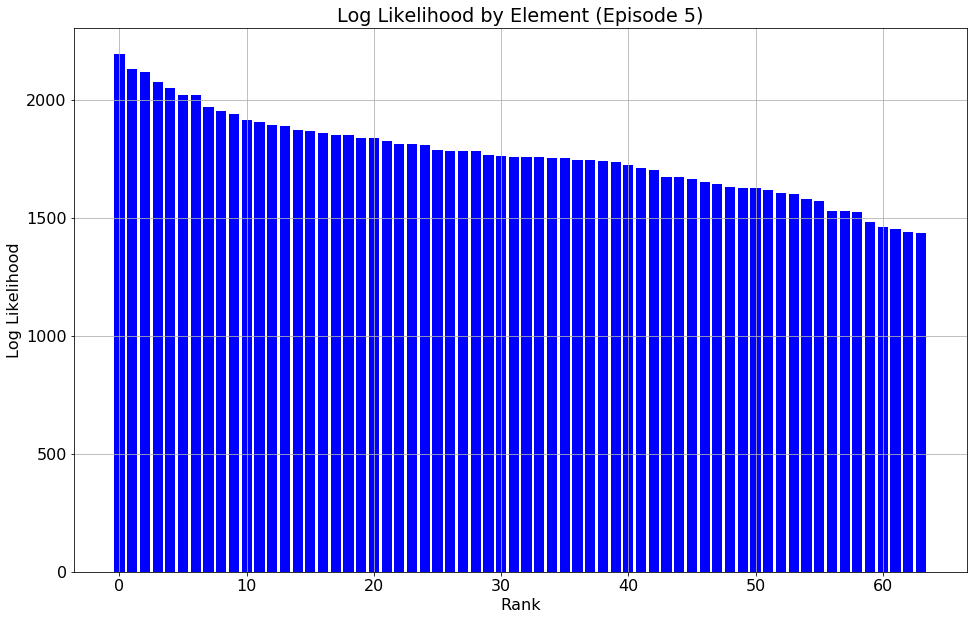

In [44]:
# Visualize log likelihood of gold model
fig, ax = model_gold.plot_bar('log_like')

In [45]:
# fig, ax = model_gold.plot_bar('hits', sorted=False)

## Check that Predicted Direction Matches Expected Direction

In [46]:
# Predicted direction
u_pred, r_pred = model_gold.predict_direction()

In [47]:
# Expected direction
cols_u = ['elt_ux', 'elt_uy', 'elt_uz']
u_true = ztf_elt_gold[cols_u].values

In [48]:
# Difference between actual and predicted
du = u_pred - u_true
u_err = np.linalg.norm(du, axis=-1)
u_err_mean = np.mean(u_err)
u_err_mean_sec = dist2sec(u_err_mean)
print(f'Mean direction error: {u_err_mean:6.2e} Cartesian / {u_err_mean_sec:6.2f} arc seconds')

Mean direction error: 7.78e-06 Cartesian /   1.60 arc seconds


## Train Model on Unperturbed Elements: Learn Mixture Parameters

In [49]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [50]:
# Build asteroid search model
model_ast = AsteroidSearchModel(
                elts=elts_ast, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model_ast')

In [ ]:
# Visualize model summary - layers and parameters
# model_ast.summary()

In [51]:
# Report before training starts
model_ast.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :     1.29  :   0.00 :  1.000000 :  3600.00
Std  :     0.68  :   0.00 :  0.000000 :     0.00
Min  :    -0.28  :   0.00 :  1.000000 :  3600.00
Max  :     2.56  :   0.00 :  1.000000 :  3600.00


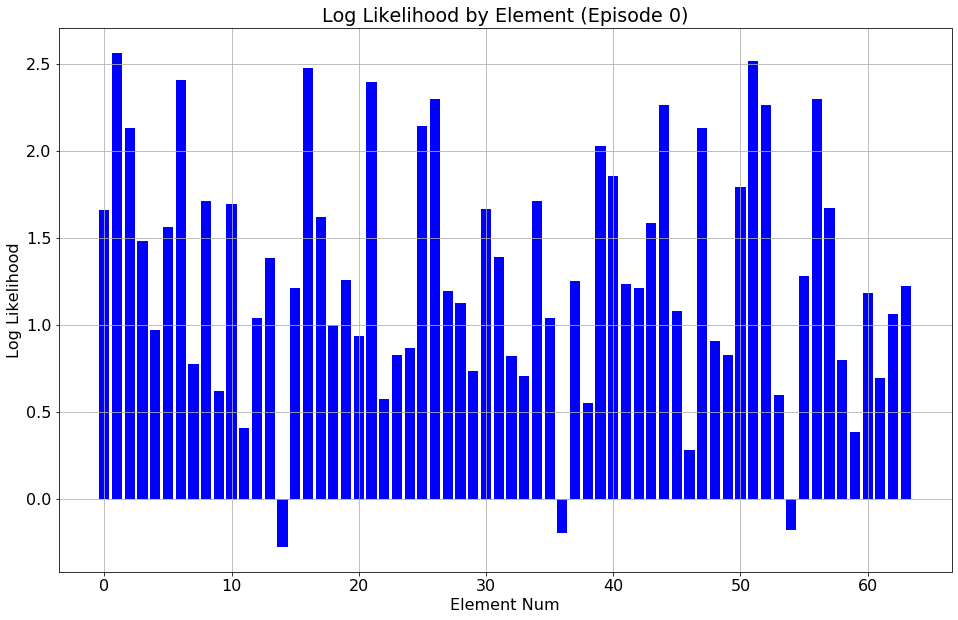

In [52]:
# Visualize log likelihood before traning
fig, ax = model_ast.plot_bar('log_like', sorted=False)

In [53]:
# Adaptive search parameters
max_batches_mixture = 10000
max_batches_element = 20000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
learning_rate = 2.0**-12
min_learning_rate = None
save_at_end = True
verbose = 1

In [54]:
# # Tiny size for fast testing
# max_batches_mixture = 1000
# verbose = 0

In [55]:
# Load model
model_ast.load()

In [56]:
model_ast.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :  1714.39  : 157.95 :  0.062956 :   226.64
Std  :   351.33  :  31.31 :  0.347903 :  1252.45
Min  :    -0.00  :   0.00 :  0.000278 :     1.00
Max  :  2193.68  : 200.99 :  2.000000 :  7200.00


In [57]:
# Preliminary round of training with frozen elements
model_ast.freeze_candidate_elements()

In [58]:
# # Train unperturbed model with frozen orbital elements
# model_ast.search_adaptive(
#     max_batches=max_batches_mixture, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     min_learning_rate=min_learning_rate,
#     save_at_end=True,
#     verbose=verbose)

In [59]:
# Report after initial training on mixture parameters
model_ast.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :  1714.39  : 157.95 :  0.062956 :   226.64
Std  :   351.33  :  31.31 :  0.347903 :  1252.45
Min  :    -0.00  :   0.00 :  0.000278 :     1.00
Max  :  2193.67  : 200.99 :  2.000000 :  7200.00


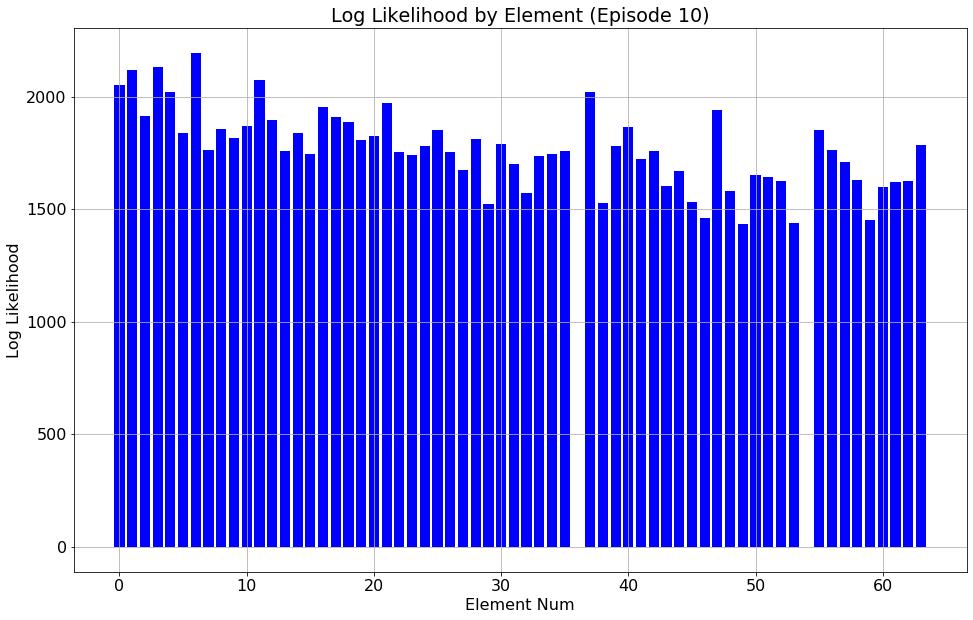

In [60]:
# Bar chart - log likelihood by element
fig, ax = model_ast.plot_bar('log_like', sorted=False)

## Train Unperturbed Model Second Time on Orbital Elements

In [61]:
# Unfreeze the elements, freeze the mixture model parameters
model_ast.thaw_candidate_elements()
model_ast.freeze_mixture_parameters()

In [62]:
model_ast.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :  1714.39  : 157.95 :  0.062956 :   226.64
Std  :   351.33  :  31.31 :  0.347903 :  1252.45
Min  :    -0.00  :   0.00 :  0.000278 :     1.00
Max  :  2193.68  : 200.99 :  2.000000 :  7200.00


In [63]:
# Train unperturbed model with frozen orbital elements
model_ast.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    save_at_end=False,
    verbose=verbose)


Training episode 10: Epoch   46, Batch   4600
effective_learning_rate=2.441e-04, training_time 102 sec.
Train on 6400 samples
Epoch 47/51
6400/6400 [==============================] - 5s 728us/sample - loss: 1569.6102
Adjusted element weight down on 62 candidate elements. Mean weight = 5.16e-01
Geom Mean Resolution: 0.000584 degrees (   2.1 arc seconds)
Mean Hits          :    157.95
Mean Log Likelihood:   1714.39

Training episode 11: Epoch   47, Batch   4700
effective_learning_rate=1.259e-04, training_time 154 sec.
Train on 6400 samples
Epoch 48/52
6400/6400 [==============================] - 2s 337us/sample - loss: 1409.7253
Adjusted element weight down on 63 candidate elements. Mean weight = 2.66e-01
Geom Mean Resolution: 0.000584 degrees (   2.1 arc seconds)
Mean Hits          :    157.95
Mean Log Likelihood:   1714.39

Training episode 12: Epoch   48, Batch   4800
effective_learning_rate=6.485e-05, training_time 157 sec.
Train on 6400 samples
Epoch 49/53
6400/6400 [==============

In [64]:
# Report after training
model_ast.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :  1714.39  : 157.95 :  0.062956 :   226.64
Std  :   351.33  :  31.31 :  0.347903 :  1252.45
Min  :     0.00  :   0.00 :  0.000278 :     1.00
Max  :  2193.68  : 200.99 :  2.000000 :  7200.00


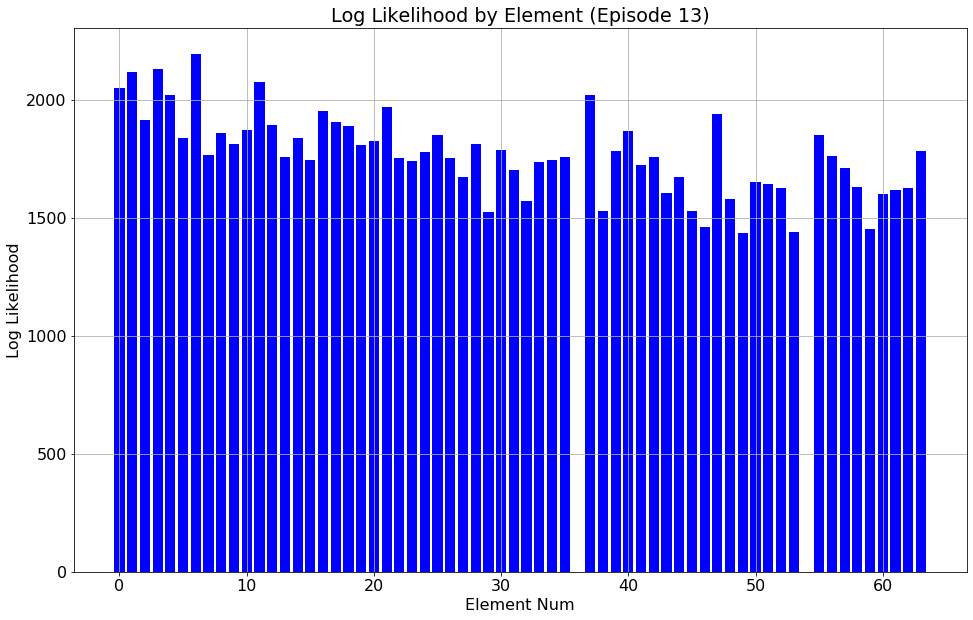

In [65]:
# Bar chart - log likelihood by element
fig, ax = model_ast.plot_bar('log_like', sorted=False)

In [66]:
# model_ast.plot_score_bar('log_like', sorted=False, episode=0)

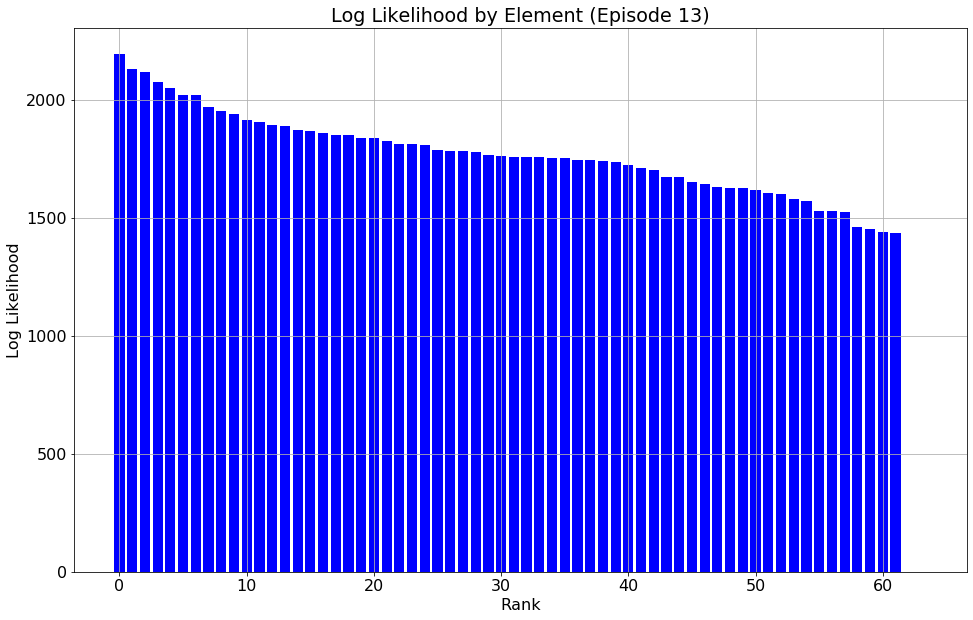

In [67]:
# Bar chart: log likelihood
fig, ax = model_ast.plot_bar('log_like')

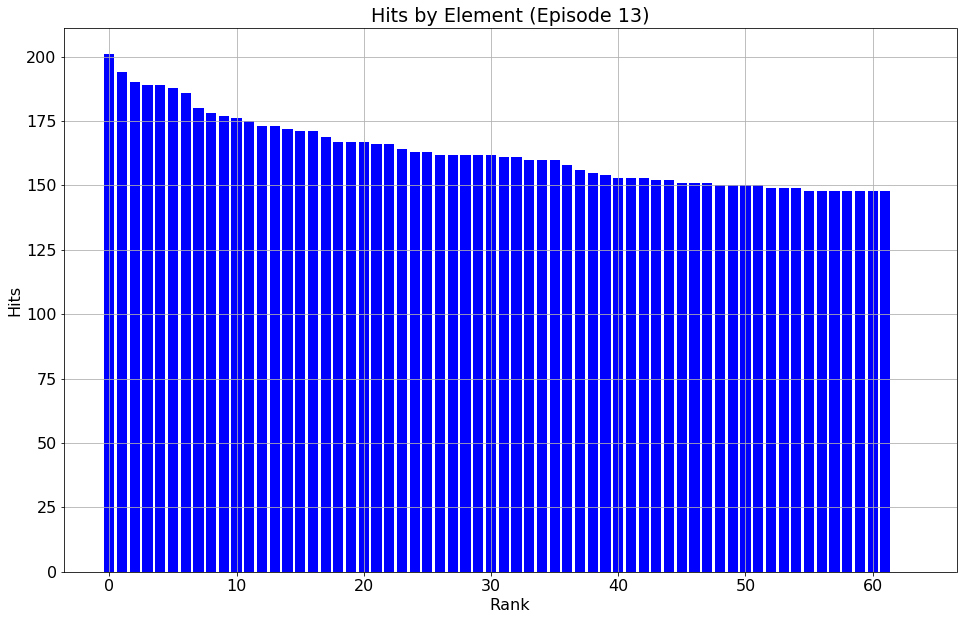

In [68]:
# Bar chart: hits
fig, ax = model_ast.plot_bar('hits')

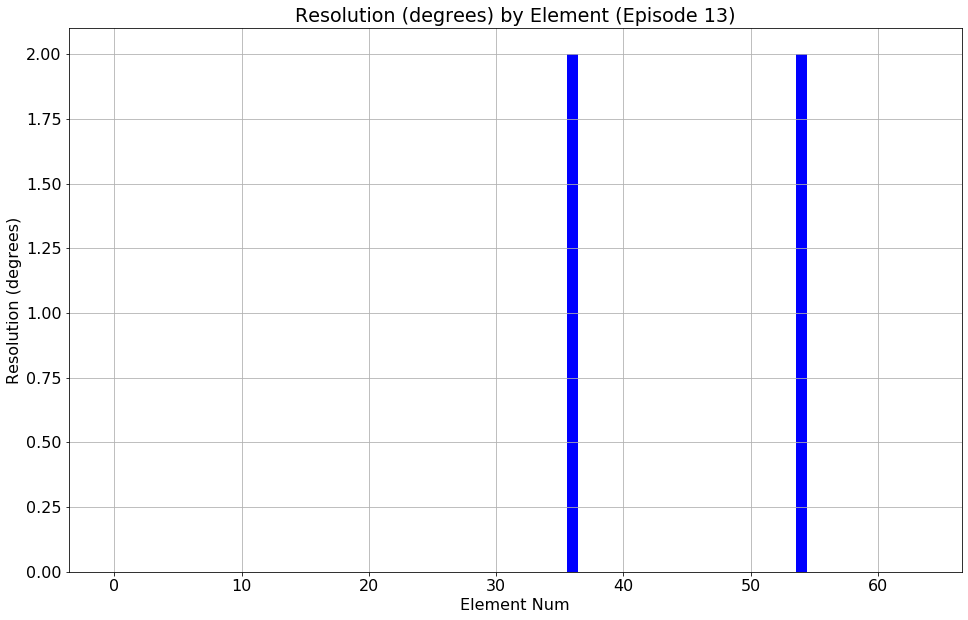

In [69]:
# Bar chart: log likelihood
fig, ax = model_ast.plot_bar('R_deg', sorted=False)

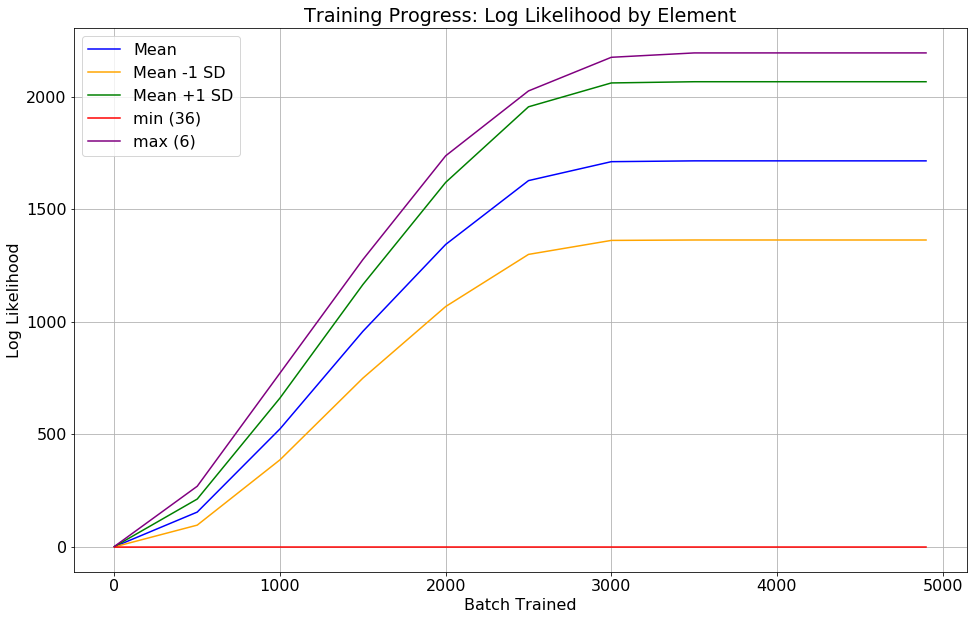

In [72]:
# Learning curve: log likelihood
fig, ax = model_ast.plot_hist('log_like')

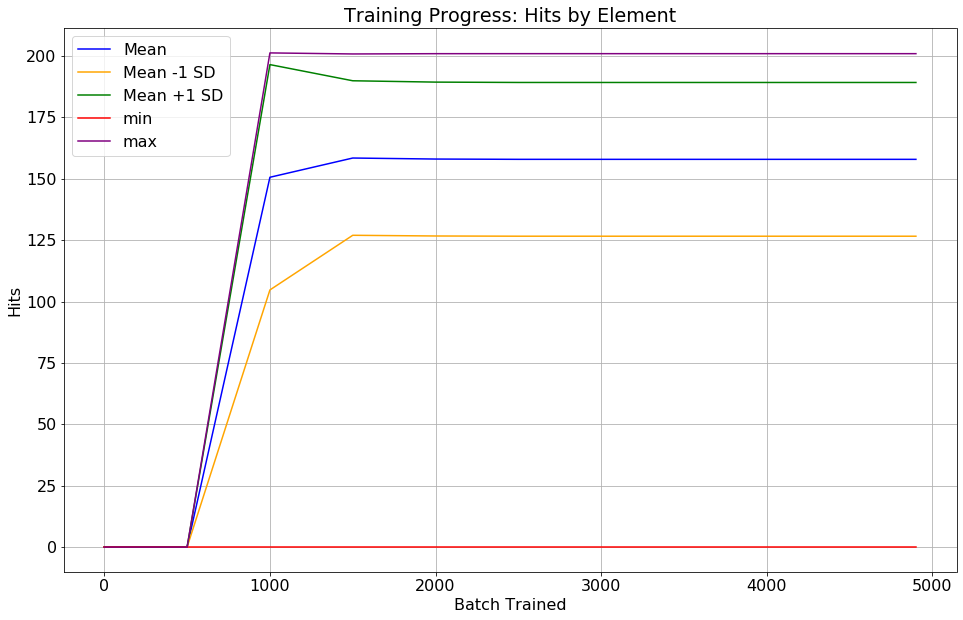

In [73]:
# Learning curve: hits
fig, ax = model_ast.plot_hist('hits')

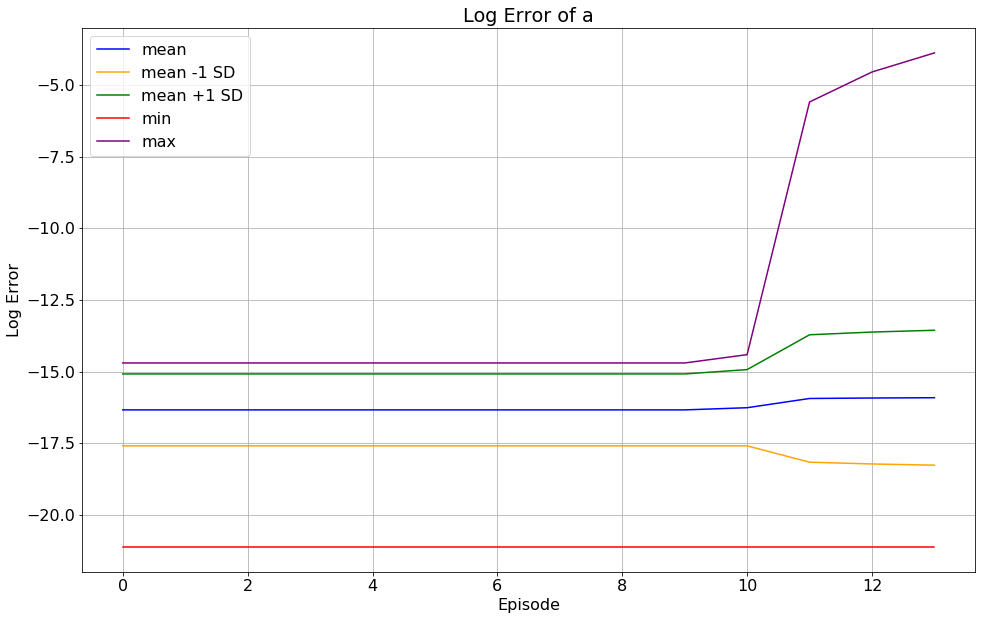

In [74]:
# Plot error in orbital elements
fig, ax = model_ast.plot_elt_error(elts_true=elts_ast, elt_name='a', is_log=True, elt_num=None)

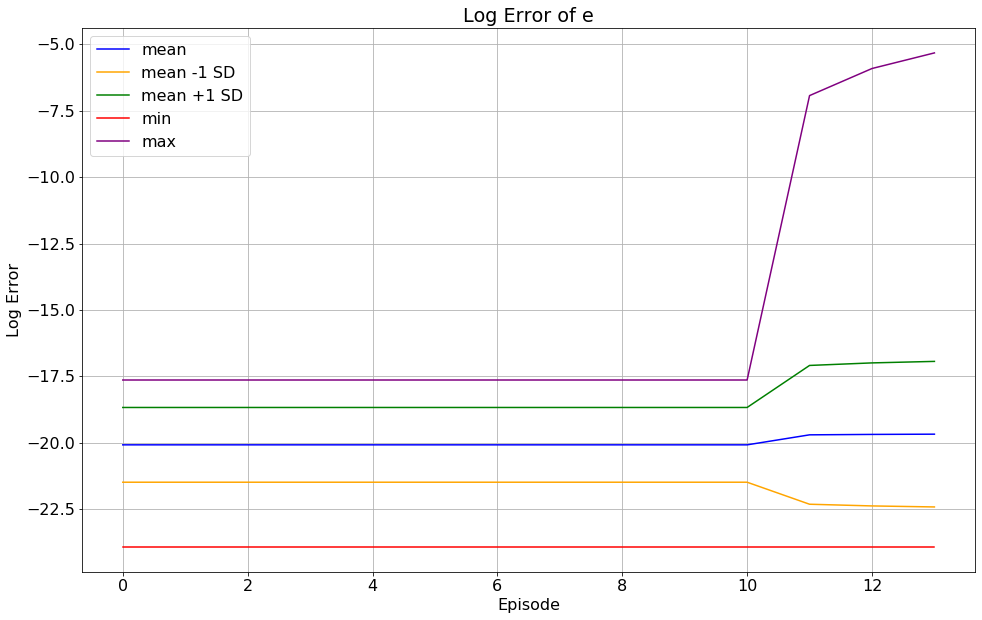

In [75]:
# Plot error in orbital elements
fig, ax = model_ast.plot_elt_error(elts_true=elts_ast, elt_name='e', is_log=True, elt_num=None)

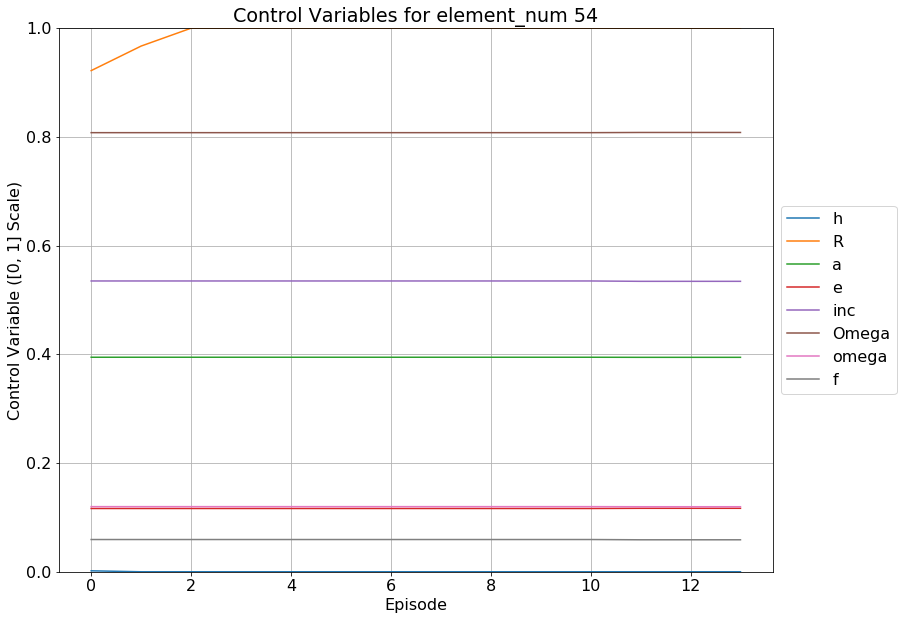

In [76]:
# Plot control variables for worst element
fig, ax = model_ast.plot_control(element_num=54)

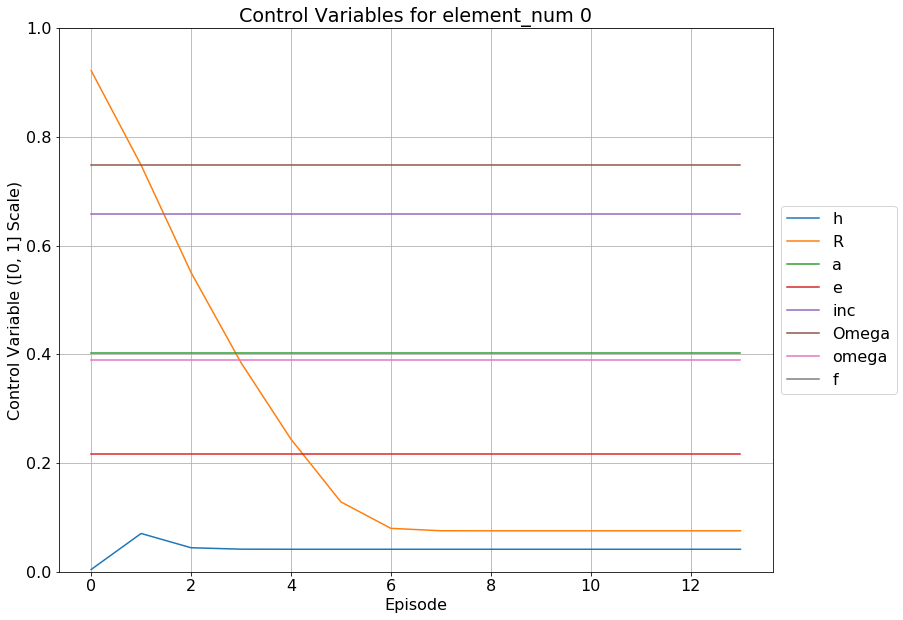

In [77]:
# Plot control variables for best element
fig, ax = model_ast.plot_control(element_num=0)

## Train on Perturbed Elements

In [79]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [81]:
# Build asteroid search model
model_pert = AsteroidSearchModel(
                elts=elts_pert, ztf_elt=ztf_elt_pert, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model_pert')

In [83]:
# Report before training starts
model_pert.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :     0.04  :   0.00 :  1.000000 :  3600.00
Std  :     0.57  :   0.00 :  0.000000 :     0.00
Min  :    -1.16  :   0.00 :  1.000000 :  3600.00
Max  :     1.89  :   0.00 :  1.000000 :  3600.00


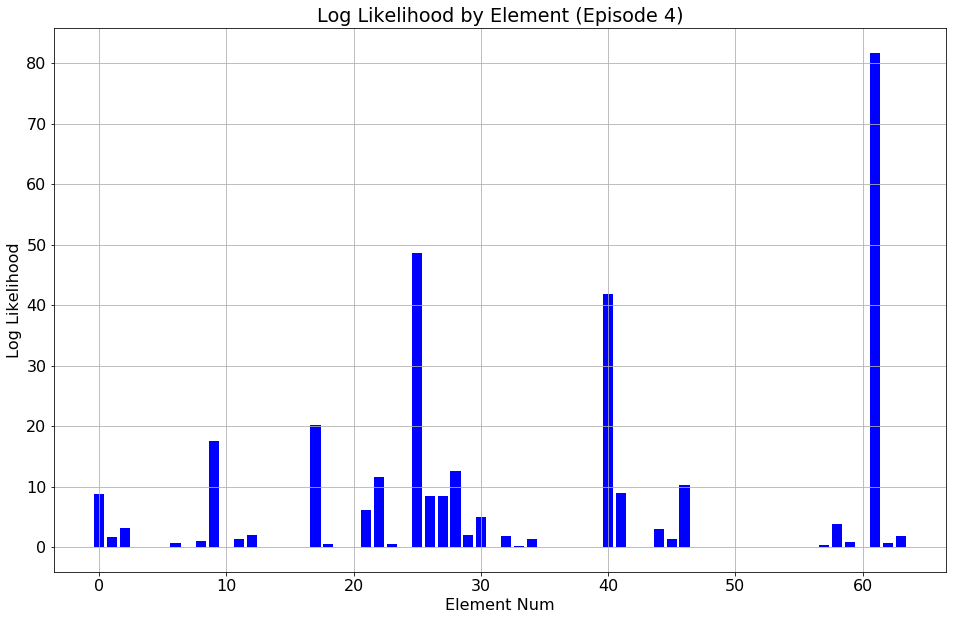

In [92]:
# Visualize log likelihood before traning
fig, ax = model_pert.plot_bar('log_like', sorted=False)

In [87]:
# Freeze elements
model_pert.freeze_candidate_elements()

In [89]:
# Adaptive search parameters
max_batches_mixture = 10000
max_batches_element = 20000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
learning_rate = 2.0**-12
min_learning_rate = None
save_at_end = True
verbose = 1

In [91]:
# Train perturbed model with frozen orbital elements
model_pert.search_adaptive(
    max_batches=max_batches_mixture, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    save_at_end=True,
    verbose=verbose)


Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 4s 583us/sample - loss: -62.1313
Epoch 2/5
6400/6400 [==============================] - 2s 274us/sample - loss: -175.2515
Epoch 3/5
6400/6400 [==============================] - 2s 271us/sample - loss: -251.0859
Epoch 4/5
6400/6400 [==============================] - 2s 275us/sample - loss: -279.7496
Epoch 5/5
6400/6400 [==============================] - 2s 269us/sample - loss: -291.8280
Geom Mean Resolution: 0.967588 degrees (3483.3 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:      4.62

Training episode 1: Epoch    5, Batch    500
effective_learning_rate=2.441e-04, training_time 159 sec.
Train on 6400 samples
Epoch 6/10
6400/6400 [==============================] - 2s 274us/sample - loss: -298.4170
Epoch 7/10
6400/6400 [==============================] - 2s 274us/sample - loss: -302.4577
Epoc

In [ ]:
# Unfreeze the elements, freeze the mixture model parameters
model_pert.thaw_candidate_elements()
model_pert.freeze_mixture_parameters()

In [ ]:
# Train unperturbed model with frozen orbital elements
model_pert.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    regenerate=True,
    verbose=verbose)

In [ ]:
model_pert.report()

## Train on Random Elements

In [ ]:
# Filter elts_rand down to only those that had matching ztf observations
idx = np.unique(ztf_elt_rand.element_id)
elts_rand = elts_rand.loc[idx]

In [ ]:
elts_rand['a'].dtype

In [ ]:
elts_rand['a'].dtype

In [ ]:
for col in ['a', 'e', 'f', 'inc', 'Omega', 'omega', 'epoch']:
    elts_rand[col] = elts_rand[col].astype(np.float32)

In [ ]:
# Build asteroid search model
model_rand = AsteroidSearchModel(
                 elts=elts_rand, ztf_elt=ztf_elt_rand, site_name=site_name,
                 thresh_deg=thresh_deg, h=h, R_deg=R_deg,
                 learning_rate=learning_rate, clipnorm=clipnorm)

In [ ]:
# Train model on perturbed elements
model_rand.search_adaptive(
    max_batches=max_batches, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    verbose=verbose)

In [ ]:
# Review likelihoods by element
log_like_rand, orbital_elements_rand, mixture_parameters_rand = model_rand.calc_outputs()

In [ ]:
log_like_rand

In [ ]:
# orbital_elements_rand